In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 876ms/step - loss: 0.4838
Average validation loss: 0.6549310088157654
4/4 [==============================] - 9s 892ms/step - loss: 0.4838 - val_loss: 0.6549
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 13s 792ms/step - loss: 0.3631 - val_loss: 0.6549
Average validation loss: 0.3001304864883423
4/4 [==============================] - 13s 807ms/step - loss: 0.3631 - val_loss: 0.4775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 16s 783ms/step - loss: 0.2877 - val_loss: 0.4775
Average validation loss: 0.1858528107404709
4/4 [==============================] - 16s 797ms/step - loss: 0.2877 - val_loss: 0.3803
Saved model weights to 'c:\Users\user\Des

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 789ms/step - loss: 0.0261
Average validation loss: 0.0
8/8 [==============================] - 6s 802ms/step - loss: 0.0261 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 716ms/step - loss: 0.0260 - val_loss: 0.0000e+00
Average validation loss: 0.0
8/8 [==============================] - 12s 727ms/step - loss: 0.0260 - val_loss: 0.0000e+00
Epoch 3/10
8/8 [==============================] - 18s 728ms/step - loss: 0.0255 - val_loss: 0.0000e+00
Average validation loss: 3.5205795612114343e-08
8/8 [==============================] - 18s 739ms/step - loss: 0.0255 - val_loss: 1.1735e-08
Epoch 4/10
8/8 [==============================] - 24s 719ms/step - loss: 0.0249 - val_loss: 1.1735e-08
Average validation loss: 0.0
8/8 [==============================] - 24s 730ms/step - loss: 0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 725ms/step - loss: 0.0327
Average validation loss: 0.17307809988657633
12/12 [==============================] - 9s 735ms/step - loss: 0.0327 - val_loss: 0.1731
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 723ms/step - loss: 0.0316 - val_loss: 0.1731
Average validation loss: 0.06364917544661826
12/12 [==============================] - 18s 736ms/step - loss: 0.0316 - val_loss: 0.1184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 717ms/step - loss: 0.0308 - val_loss: 0.1184
Average validation loss: 0.04935752128828123
12/12 [==============================] - 27s 728ms/step - loss: 0.0308 - val_loss: 0.0954
Saved model weights to '

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 719ms/step - loss: 0.0255
Average validation loss: 0.15991206606881114
16/16 [==============================] - 12s 731ms/step - loss: 0.0255 - val_loss: 0.1599
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 750ms/step - loss: 0.0269 - val_loss: 0.1599
Average validation loss: 0.11372995183609141
16/16 [==============================] - 24s 764ms/step - loss: 0.0269 - val_loss: 0.1368
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 735ms/step - loss: 0.0261 - val_loss: 0.1368
Average validation loss: 0.08825300394336111
16/16 [==============================] - 36s 747ms/step - loss: 0.0261 - val_loss: 0.1206
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 740ms/step - loss: 0.0188
Average validation loss: 0.30703400074653475
20/20 [==============================] - 15s 752ms/step - loss: 0.0188 - val_loss: 0.3070
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 721ms/step - loss: 0.0174 - val_loss: 0.3070
Average validation loss: 0.031840046495199205
20/20 [==============================] - 30s 734ms/step - loss: 0.0174 - val_loss: 0.1694
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 724ms/step - loss: 0.0166 - val_loss: 0.1694
Average validation loss: 0.08525157749718346
20/20 [==============================] - 45s 737ms/step - loss: 0.0166 - val_loss: 0.1414
Epoch 4/10
20/20 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 747ms/step - loss: 0.0161
Average validation loss: 0.02881354745477438
24/24 [==============================] - 18s 761ms/step - loss: 0.0161 - val_loss: 0.0288
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 36s 742ms/step - loss: 0.0152 - val_loss: 0.0288
Average validation loss: 0.03585330272714297
24/24 [==============================] - 36s 756ms/step - loss: 0.0152 - val_loss: 0.0323
Epoch 3/10
24/24 [==============================] - 54s 721ms/step - loss: 0.0149 - val_loss: 0.0323
Average validation loss: 0.08648957063754399
24/24 [==============================] - 54s 735ms/step - loss: 0.0149 - val_loss: 0.0504
Epoch 4/10
24/24 [==============================] - 71s 723ms/step - loss: 0.0140 - val_loss: 0.0504
Average validation loss: 0.05103017141421636
24/24 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 722ms/step - loss: 0.0258
Average validation loss: 0.062417852133512496
40/40 [==============================] - 29s 734ms/step - loss: 0.0258 - val_loss: 0.0624
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 726ms/step - loss: 0.0239 - val_loss: 0.0624
Average validation loss: 0.06752915829420089
40/40 [==============================] - 59s 738ms/step - loss: 0.0239 - val_loss: 0.0650
Epoch 3/10
40/40 [==============================] - 88s 722ms/step - loss: 0.0222 - val_loss: 0.0650
Average validation loss: 0.033276238664984706
40/40 [==============================] - 88s 734ms/step - loss: 0.0222 - val_loss: 0.0544
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_50.pth'.
Epoch 4/10
40/40 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 731ms/step - loss: 0.0180
Average validation loss: 0.016941215600430343
48/48 [==============================] - 36s 745ms/step - loss: 0.0180 - val_loss: 0.0169
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 741ms/step - loss: 0.0152 - val_loss: 0.0169
Average validation loss: 0.010663115044735605
48/48 [==============================] - 72s 753ms/step - loss: 0.0152 - val_loss: 0.0138
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 107s 734ms/step - loss: 0.0132 - val_loss: 0.0138
Average validation loss: 0.009804792132248016
48/48 [==============================] - 108s 746ms/step - loss: 0.0132 - val_loss: 0.0125
Saved model weigh

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 42s 743ms/step - loss: 0.0191
Average validation loss: 0.015639714896678925
56/56 [==============================] - 42s 756ms/step - loss: 0.0191 - val_loss: 0.0156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 83s 733ms/step - loss: 0.0146 - val_loss: 0.0156
Average validation loss: 0.05163311708851585
56/56 [==============================] - 84s 746ms/step - loss: 0.0146 - val_loss: 0.0336
Epoch 3/10
56/56 [==============================] - 126s 738ms/step - loss: 0.0126 - val_loss: 0.0336
Average validation loss: 0.019669846807248956
56/56 [==============================] - 126s 751ms/step - loss: 0.0126 - val_loss: 0.0290
Epoch 4/10
56/56 [==============================] - 167s 735ms/step - loss: 0.0111 - val_loss: 0.0290
Average validation loss: 0.01467664455828656
56/56 [==============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 735ms/step - loss: 0.0129
Average validation loss: 0.05053766582228647
64/64 [==============================] - 48s 748ms/step - loss: 0.0129 - val_loss: 0.0505
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 95s 734ms/step - loss: 0.0099 - val_loss: 0.0505
Average validation loss: 0.008338845751495683
64/64 [==============================] - 96s 747ms/step - loss: 0.0099 - val_loss: 0.0294
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 143s 736ms/step - loss: 0.0084 - val_loss: 0.0294
Average validation loss: 0.008584612550293969
64/64 [==============================] - 144s 749ms/step - loss: 0.0084 - val_loss: 0.0225
Epoch 4/10
64/64 [

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 53s 735ms/step - loss: 0.0134
Average validation loss: 0.0064071172123981845
72/72 [==============================] - 54s 748ms/step - loss: 0.0134 - val_loss: 0.0064
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 107s 732ms/step - loss: 0.0105 - val_loss: 0.0064
Average validation loss: 0.007426261565544539
72/72 [==============================] - 108s 746ms/step - loss: 0.0105 - val_loss: 0.0069
Epoch 3/10
72/72 [==============================] - 160s 731ms/step - loss: 0.0087 - val_loss: 0.0069
Average validation loss: 0.013738294882285926
72/72 [==============================] - 161s 744ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 4/10
72/72 [==============================] - 214s 732ms/step - loss: 0.0077 - val_loss: 0.0092
Average validation loss: 0.006881395438944714
72/72 [=========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 59s 733ms/step - loss: 0.0109
Average validation loss: 0.005890749034006148
80/80 [==============================] - 60s 746ms/step - loss: 0.0109 - val_loss: 0.0059
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 118s 730ms/step - loss: 0.0082 - val_loss: 0.0059
Average validation loss: 0.005651379190385342
80/80 [==============================] - 119s 743ms/step - loss: 0.0082 - val_loss: 0.0058
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 178s 732ms/step - loss: 0.0072 - val_loss: 0.0058
Average validation loss: 0.005587645858759061
80/80 [==============================] - 179s 745ms/step - loss: 0.0072 - val_loss: 0.0057
Saved model w

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 731ms/step - loss: 0.0167
Average validation loss: 0.024209638494842995
96/96 [==============================] - 71s 744ms/step - loss: 0.0167 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 142s 729ms/step - loss: 0.0136 - val_loss: 0.0242
Average validation loss: 0.031984923397430975
96/96 [==============================] - 143s 741ms/step - loss: 0.0136 - val_loss: 0.0281
Epoch 3/10
96/96 [==============================] - 212s 721ms/step - loss: 0.0112 - val_loss: 0.0281
Average validation loss: 0.02301408682372615
96/96 [==============================] - 213s 734ms/step - loss: 0.0112 - val_loss: 0.0264
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_120.pth'.
Epoch 4/10
96/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 719ms/step - loss: 0.0124
Average validation loss: 0.010053994663743045
120/120 [==============================] - 88s 732ms/step - loss: 0.0124 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 724ms/step - loss: 0.0101 - val_loss: 0.0101
Average validation loss: 0.010335292989232888
120/120 [==============================] - 176s 737ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 3/10
120/120 [==============================] - 263s 723ms/step - loss: 0.0087 - val_loss: 0.0102
Average validation loss: 0.006568719163139273
120/120 [==============================] - 265s 735ms/step - loss: 0.0087 - val_loss: 0.0090
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_150.pth'.
E

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 0.0109
Average validation loss: 0.007216362505763148
144/144 [==============================] - 105s 732ms/step - loss: 0.0109 - val_loss: 0.0072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 721ms/step - loss: 0.0085 - val_loss: 0.0072
Average validation loss: 0.008641889836225245
144/144 [==============================] - 211s 733ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 3/10
144/144 [==============================] - 315s 719ms/step - loss: 0.0071 - val_loss: 0.0079
Average validation loss: 0.009787220372648639
144/144 [==============================] - 317s 732ms/step - loss: 0.0071 - val_loss: 0.0085
Epoch 4/10
144/144 [==============================] - 420s 719ms/step - loss: 0.0064 - val_loss: 0.0085
Average validation loss: 0.008962561667835366


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 0.0075
Average validation loss: 0.005144479067894281
160/160 [==============================] - 117s 733ms/step - loss: 0.0075 - val_loss: 0.0051
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 234s 728ms/step - loss: 0.0060 - val_loss: 0.0051
Average validation loss: 0.004958320210971578
160/160 [==============================] - 236s 740ms/step - loss: 0.0060 - val_loss: 0.0051
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 352s 725ms/step - loss: 0.0057 - val_loss: 0.0051
Average validation loss: 0.004955839931608352
160/160 [==============================] - 354s 738ms/step - loss: 0.0057 - val_loss: 0.0050

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0140
Average validation loss: 0.006760993003699696
200/200 [==============================] - 147s 732ms/step - loss: 0.0140 - val_loss: 0.0068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 721ms/step - loss: 0.0110 - val_loss: 0.0068
Average validation loss: 0.00745483573526144
200/200 [==============================] - 293s 733ms/step - loss: 0.0110 - val_loss: 0.0071
Epoch 3/10
200/200 [==============================] - 438s 722ms/step - loss: 0.0093 - val_loss: 0.0071
Average validation loss: 0.006495834675442893
200/200 [==============================] - 440s 734ms/step - loss: 0.0093 - val_loss: 0.0069
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_250.pth'.


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:50 - loss: 0.0034

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 724ms/step - loss: 0.0084
Average validation loss: 0.008255411809140393
240/240 [==============================] - 177s 736ms/step - loss: 0.0084 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 350s 724ms/step - loss: 0.0067 - val_loss: 0.0083
Average validation loss: 0.008789183415046864
240/240 [==============================] - 353s 737ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 3/10
240/240 [==============================] - 526s 720ms/step - loss: 0.0057 - val_loss: 0.0085
Average validation loss: 0.009727373350809405
240/240 [==============================] - 529s 732ms/step - loss: 0.0057 - val_loss: 0.0089
Epoch 4/10
240/240 [==============================] - 702s 721ms/step - loss: 0.0053 - val_loss: 0.0089
Average validation loss: 0.014059961539645964


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08808643317631848, 0.17173955458429607, 0.15811406679863796, 0.1284144545364311, 0.06497500807411086, 0.04287022294695191, 0.02917470424302291, 0.017787544456492006, 0.01837245702377814, 0.019819956778072162, 0.005634164004623838, 0.006102884425960951, 0.010334184412554848, 0.007524360829782077, 0.005428634390308594, 0.00395243231509859, 0.005467639621483886, 0.005722169817197155]
std_val_losses =  [0.15445658110306135, 0.3863451611937486, 0.16202972728947213, 0.10313475955494769, 0.06480573216052937, 0.05426833768603574, 0.023328402012375994, 0.01929278007779047, 0.01676061930420073, 0.052598437523231366, 0.0022279256493989174, 0.0037741395801831647, 0.011088136862690424, 0.0070129431692167715, 0.0028633681306696056, 0.0011961390733072755, 0.003930263916205056, 0.0038050989763236957]


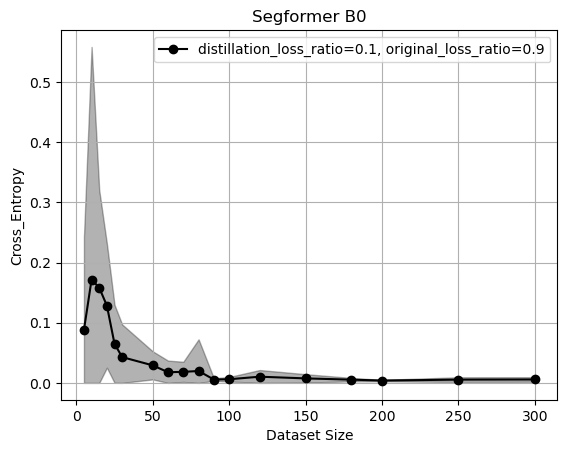

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()